# Demo: Evaluation on ClinicalNotes v0

This demo provides a walk-through of:
1. How to use the ClinicalNotes datasets for CCR evaluation.
   - Standard metrics: F1, accuracy, precision, recall.
   - Metrics for counterfactual reasoning evaluation: external validity RAE and internal consistency RAE.
2. How to generate new random ClinicalNotes tasks.

For more information on the counterfactual reasoning metrics, see [Maasch et al. 2025 (ICML)](https://arxiv.org/abs/2503.04556).

Code by Jacqueline Maasch | April 2025

In [1]:
# General importations.
import pandas as pd
import numpy as np
import os
import sys
from ast import literal_eval
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import Utils
from clinical_notes import ClinicalNotes

In [2]:
u = Utils()

In [3]:
path = "../static_datasets/clinical_notes_v0/"

## Import static datasets

In [4]:
# Load raw data.
df = pd.read_csv(path+"clinical_notes_v0.csv")
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Task ID                                 60000 non-null  float64
 1   Context ID                              60000 non-null  int64  
 2   Sample ID                               60000 non-null  int64  
 3   Replicate ID                            60000 non-null  int64  
 4   Nodes per BCC                           60000 non-null  object 
 5   DAG adjacency matrix                    60000 non-null  object 
 6   DAG nodes                               60000 non-null  object 
 7   CCT adjacency matrix                    60000 non-null  object 
 8   CCT nodes                               60000 non-null  object 
 9   Exogenous variables                     60000 non-null  object 
 10  Bernoulli parameters                    60000 non-null  ob

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Exogenous variables,Bernoulli parameters,Global quantity,Local quantities,Compositions,Causal context,Sample context,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0.0,0,0,0,"[2, 2]",[[0 1 0]\n [0 0 1]\n [0 0 0]],"['pain', 'VGJS', 'surgery']",[[0. 1. 1.]\n [0. 0. 1.]\n [0. 0. 0.]],"['pain', 'VGJS', 'surgery']","['LTMZ', 'G9TD', 'XD0U']","[0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'VGJS'), ('VGJS', 'surgery')]","[[('pain', 'VGJS'), ('VGJS', 'surgery')]]",Chronic disease G5HW23 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.0,0,0,1,"[2, 2]",[[0 1 0]\n [0 0 1]\n [0 0 0]],"['pain', 'VGJS', 'surgery']",[[0. 1. 1.]\n [0. 0. 1.]\n [0. 0. 0.]],"['pain', 'VGJS', 'surgery']","['LTMZ', 'G9TD', 'XD0U']","[0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'VGJS'), ('VGJS', 'surgery')]","[[('pain', 'VGJS'), ('VGJS', 'surgery')]]",Chronic disease G5HW23 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.0,0,0,2,"[2, 2]",[[0 1 0]\n [0 0 1]\n [0 0 0]],"['pain', 'VGJS', 'surgery']",[[0. 1. 1.]\n [0. 0. 1.]\n [0. 0. 0.]],"['pain', 'VGJS', 'surgery']","['LTMZ', 'G9TD', 'XD0U']","[0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'VGJS'), ('VGJS', 'surgery')]","[[('pain', 'VGJS'), ('VGJS', 'surgery')]]",Chronic disease G5HW23 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.0,0,0,3,"[2, 2]",[[0 1 0]\n [0 0 1]\n [0 0 0]],"['pain', 'VGJS', 'surgery']",[[0. 1. 1.]\n [0. 0. 1.]\n [0. 0. 0.]],"['pain', 'VGJS', 'surgery']","['LTMZ', 'G9TD', 'XD0U']","[0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'VGJS'), ('VGJS', 'surgery')]","[[('pain', 'VGJS'), ('VGJS', 'surgery')]]",Chronic disease G5HW23 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.0,0,0,4,"[2, 2]",[[0 1 0]\n [0 0 1]\n [0 0 0]],"['pain', 'VGJS', 'surgery']",[[0. 1. 1.]\n [0. 0. 1.]\n [0. 0. 0.]],"['pain', 'VGJS', 'surgery']","['LTMZ', 'G9TD', 'XD0U']","[0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'VGJS'), ('VGJS', 'surgery')]","[[('pain', 'VGJS'), ('VGJS', 'surgery')]]",Chronic disease G5HW23 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."


In [5]:
# Convert adjacency matrices back to numpy arrays.
def string_to_array(array_string):
    cleaned_string = array_string.replace('\n', '')
    cleaned_string = cleaned_string.replace(' ', ', ')
    new_list = literal_eval(cleaned_string)
    return np.array(new_list)

print(string_to_array(df["DAG adjacency matrix"][0]))

df["DAG adjacency matrix"] = df["DAG adjacency matrix"].apply(string_to_array)

[[0 1 0]
 [0 0 1]
 [0 0 0]]


In [6]:
# Total observations per Context ID.
df["Context ID"].value_counts()

Context ID
0     5000
1     5000
2     5000
3     5000
4     5000
5     5000
6     5000
7     5000
8     5000
9     5000
10    5000
11    5000
Name: count, dtype: int64

In [7]:
# Total observations per graph size.
df["Nodes per BCC"].value_counts()

Nodes per BCC
[2, 2]    15000
[3, 3]    15000
[4, 4]    15000
[5, 5]    15000
Name: count, dtype: int64

In [8]:
# Load factual prompts.
df_f = pd.read_csv(path+"clinical_notes_factual_v0.csv")
print(df_f.info())
display(df_f.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Task ID        120000 non-null  float64
 1   Context ID     120000 non-null  int64  
 2   Sample ID      120000 non-null  int64  
 3   Replicate ID   120000 non-null  int64  
 4   Nodes per BCC  120000 non-null  object 
 5   Effect         120000 non-null  object 
 6   Prompt         120000 non-null  object 
 7   True           120000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 7.3+ MB
None


,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Effect,Prompt,True
0,0.0,0,0,0,"[2, 2]",surgery,Chronic disease G5HW23 sometimes requires surg...,1
1,0.0,0,0,0,"[2, 2]",VGJS,Chronic disease G5HW23 sometimes requires surg...,1
2,0.0,0,0,1,"[2, 2]",surgery,Chronic disease G5HW23 sometimes requires surg...,1
3,0.0,0,0,1,"[2, 2]",VGJS,Chronic disease G5HW23 sometimes requires surg...,1
4,0.0,0,0,2,"[2, 2]",surgery,Chronic disease G5HW23 sometimes requires surg...,1


In [9]:
# Load counterfactual prompts.
df_cf = pd.read_csv(path+"clinical_notes_counterfactual_v0.csv")
print(df_cf.info())
display(df_cf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Task ID                 180000 non-null  float64
 1   Context ID              180000 non-null  int64  
 2   Sample ID               180000 non-null  int64  
 3   Replicate ID            180000 non-null  int64  
 4   Nodes per BCC           180000 non-null  object 
 5   Cause-effect pair       180000 non-null  object 
 6   Cause                   180000 non-null  object 
 7   Effect                  180000 non-null  object 
 8   Prompt (cause = True)   180000 non-null  object 
 9   True (cause = True)     180000 non-null  int64  
 10  Prompt (cause = False)  180000 non-null  object 
 11  True (cause = False)    180000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 16.5+ MB
None


,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0.0,0,0,0,"[2, 2]","('pain', 'surgery')",pain,surgery,Chronic disease G5HW23 sometimes requires surg...,1,Chronic disease G5HW23 sometimes requires surg...,0
1,0.0,0,0,0,"[2, 2]","('pain', 'VGJS')",pain,VGJS,Chronic disease G5HW23 sometimes requires surg...,1,Chronic disease G5HW23 sometimes requires surg...,0
2,0.0,0,0,0,"[2, 2]","('VGJS', 'surgery')",VGJS,surgery,Chronic disease G5HW23 sometimes requires surg...,1,Chronic disease G5HW23 sometimes requires surg...,0
3,0.0,0,0,1,"[2, 2]","('pain', 'surgery')",pain,surgery,Chronic disease G5HW23 sometimes requires surg...,1,Chronic disease G5HW23 sometimes requires surg...,0
4,0.0,0,0,1,"[2, 2]","('pain', 'VGJS')",pain,VGJS,Chronic disease G5HW23 sometimes requires surg...,1,Chronic disease G5HW23 sometimes requires surg...,0


In [10]:
# Load ground truth PNS values.
pns_dict = np.load(path+"clinical_notes_pns_dict_v0.npy",
                   allow_pickle = "TRUE").item()
display(pns_dict)

{0: {"('pain', 'surgery')": 0.255,
  "('pain', 'VGJS')": 0.507,
  "('VGJS', 'surgery')": 0.489,
  "[('pain', 'VGJS'), ('VGJS', 'surgery')]": 0.247923},
 1: {"('pain', 'surgery')": 0.244,
  "('pain', '4ZDL')": 0.504,
  "('4ZDL', 'surgery')": 0.484,
  "[('pain', '4ZDL'), ('4ZDL', 'surgery')]": 0.243936},
 2: {"('pain', 'surgery')": 0.239,
  "('pain', 'DP8H')": 0.476,
  "('DP8H', 'surgery')": 0.479,
  "[('pain', 'DP8H'), ('DP8H', 'surgery')]": 0.22800399999999998},
 3: {"('pain', 'surgery')": 0.127,
  "('pain', 'G883')": 0.262,
  "('G883', 'surgery')": 0.466,
  "[('pain', 'G883'), ('G883', 'surgery')]": 0.122092},
 4: {"('pain', 'surgery')": 0.134,
  "('pain', 'HSP3')": 0.261,
  "('HSP3', 'surgery')": 0.524,
  "[('pain', 'HSP3'), ('HSP3', 'surgery')]": 0.13676400000000002},
 5: {"('pain', 'surgery')": 0.124,
  "('pain', '0G5T')": 0.242,
  "('0G5T', 'surgery')": 0.487,
  "[('pain', '0G5T'), ('0G5T', 'surgery')]": 0.117854},
 6: {"('pain', 'surgery')": 0.068,
  "('pain', '8YFC')": 0.118,
  

In [11]:
# Load thresholds for internal consistency evaluation.
# By default, the multiplier was 1.0
# Here, we want a multiplier of 1.1, so we will update these values later.
threshold_dict = np.load(path+"clinical_notes_threshold_dict_v0.npy",
                         allow_pickle = "TRUE").item()
display(threshold_dict)

{0: {"[('pain', 'VGJS'), ('VGJS', 'surgery')]": 0.027752941176470588},
 1: {"[('pain', '4ZDL'), ('4ZDL', 'surgery')]": 0.00026229508196724794},
 2: {"[('pain', 'DP8H'), ('DP8H', 'surgery')]": 0.04600836820083685},
 3: {"[('pain', 'G883'), ('G883', 'surgery')]": 0.03864566929133855},
 4: {"[('pain', 'HSP3'), ('HSP3', 'surgery')]": 0.020626865671641913},
 5: {"[('pain', '0G5T'), ('0G5T', 'surgery')]": 0.049564516129032246},
 6: {"[('pain', '8YFC'), ('8YFC', 'surgery')]": 0.08723529411764715},
 7: {"[('pain', '5FQY'), ('5FQY', 'surgery')]": 0.03199999999999999},
 8: {"[('pain', 'TGJG'), ('TGJG', 'surgery')]": 0.031186440677966245},
 9: {"[('pain', 'DJF5'), ('DJF5', 'surgery')]": 0.11434782608695654},
 10: {"[('pain', 'RJDR'), ('RJDR', 'surgery')]": 0.056774193548387246},
 11: {"[('pain', 'KHIU'), ('KHIU', 'surgery')]": 0.029292682926829284}}

## Simulate evaluation and error analysis

Subsample a single Context ID. For illustration, we will focus on Context 0.

In [12]:
# Sample Context 0.
df_0 = df[df["Context ID"] == 0]
df_f_0 = df_f[df_f["Context ID"] == 0]
df_cf_0 = df_cf[df_cf["Context ID"] == 0]

print(len(df_0))
print(len(df_f_0))
print(len(df_cf_0))

5000
10000
15000


In [13]:
df_0.columns

Index(['Task ID', 'Context ID', 'Sample ID', 'Replicate ID', 'Nodes per BCC',
       'DAG adjacency matrix', 'DAG nodes', 'CCT adjacency matrix',
       'CCT nodes', 'Exogenous variables', 'Bernoulli parameters',
       'Global quantity', 'Local quantities', 'Compositions', 'Causal context',
       'Sample context', 'Factual queries',
       'Counterfactual queries (cause = True)',
       'Counterfactual queries (cause = False)'],
      dtype='object')

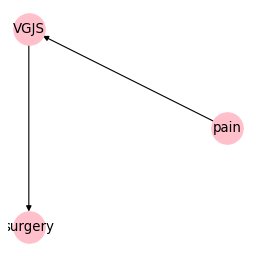

In [14]:
# View causal DAG (endogenous variables only).
u.plot_nx(df_0["DAG adjacency matrix"][0],
          labels = literal_eval(df_0["DAG nodes"][0]),
          figsize = (3,3), 
          dpi = 80)

### Associational level: Evaluate factual responses

In [15]:
# Perturb true responses to obtain synthetic predictions.
f_true = df_f_0["True"].to_numpy()
idx = np.random.choice(np.arange(len(f_true)), size = int(len(f_true)/10), replace = False)
f_pred = [f_true[i] if i not in idx else 1-f_true[i] for i in range(len(f_true))]
print(sum(np.where(f_pred != f_true, True, False)))

1000


In [16]:
# Treat responses for all effects as one long vector.
# A finer-grained analysis would compute metrics separately for each effect.
print("F1        =", f1_score(f_true, f_pred))
print("Precision =", precision_score(f_true, f_pred))
print("Recall    =", recall_score(f_true, f_pred))
print("Accuracy  =", accuracy_score(f_true, f_pred))

F1        = 0.9101850188611461
Precision = 0.9239606126914661
Recall    = 0.8968141592920355
Accuracy  = 0.9


### Interventional level: Evaluate interventional responses

In [17]:
# Intervention (cause = True).
do_1_true = df_cf_0["True (cause = True)"].to_numpy()
idx = np.random.choice(np.arange(len(do_1_true)), size = int(len(do_1_true)/10), replace = False)
do_1_pred = [do_1_true[i] if i not in idx else 1-do_1_true[i] for i in range(len(do_1_true))]
print(sum(np.where(do_1_pred != do_1_true, True, False)))

1500


In [18]:
# Treat responses for all cause-effect pairs as one long vector.
# A finer-grained analysis would compute metrics separately for each cause-effect pair.
print("F1        =", f1_score(do_1_true, do_1_pred))
print("Precision =", precision_score(do_1_true, do_1_pred))
print("Recall    =", recall_score(do_1_true, do_1_pred))
print("Accuracy  =", accuracy_score(do_1_true, do_1_pred))

F1        = 0.9221991701244814
Precision = 0.946751863684771
Recall    = 0.8988877654196158
Accuracy  = 0.9


In [19]:
# Intervention (cause = False).
do_0_true = df_cf_0["True (cause = False)"].to_numpy()
idx = np.random.choice(np.arange(len(do_0_true)), size = int(len(do_0_true)/10), replace = False)
do_0_pred = [do_0_true[i] if i not in idx else 1-do_0_true[i] for i in range(len(do_0_true))]
print(sum(np.where(do_0_pred != do_0_true, True, False)))

1500


In [20]:
# Treat responses for all cause-effect pairs as one long vector.
# A finer-grained analysis would compute metrics separately for each cause-effect pair.
print("F1        =", f1_score(do_0_true, do_0_pred))
print("Precision =", precision_score(do_0_true, do_0_pred))
print("Recall    =", recall_score(do_0_true, do_0_pred))
print("Accuracy  =", accuracy_score(do_0_true, do_0_pred))

F1        = 0.8142184790686153
Precision = 0.7404820905609372
Recall    = 0.9042640990371389
Accuracy  = 0.9


### Counterfactual level: Evaluate PNS external validity and internal consistency

#### External validity of individual causal measures

In [21]:
# Compute PNS estimates for each cause-effect pair.
# For illustration, we will demonstrate on (pain,surgery).
df_pred = pd.DataFrame({"Cause = True": do_1_pred, 
                        "Cause = False": do_0_pred})
pns_pred = u.get_pns_direct(df_pred,
                            y_do_x1 = "Cause = True", 
                            y_do_x0 = "Cause = False")
pns_true = pns_dict.get(0).get("('pain', 'surgery')")
external_validity_rae = u.get_rae(pns_true, pns_pred)

print("True PNS              =", pns_true)
print("Predicted PNS         =", pns_pred)
print("External validity RAE =", external_validity_rae)

True PNS              = 0.255
Predicted PNS         = 0.38693333333333335
External validity RAE = 0.5173856209150327


In [22]:
pns_dict.get(0)

{"('pain', 'surgery')": 0.255,
 "('pain', 'VGJS')": 0.507,
 "('VGJS', 'surgery')": 0.489,
 "[('pain', 'VGJS'), ('VGJS', 'surgery')]": 0.247923}

#### Internal consistency and external validity of compositions

In [23]:
%%capture
# Compute PNS for composition.
# We will perturb the true values to simulate LM responses with errors.
df_pain_VGJS = df_cf_0[df_cf_0["Cause-effect pair"] == "('pain', 'VGJS')"]
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_pain_VGJS["True (cause = True)"].to_numpy()
df_pain_VGJS["Pred (cause = True)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_pain_VGJS["True (cause = False)"].to_numpy()
df_pain_VGJS["Pred (cause = False)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

pns_pain_VGJS = u.get_pns_direct(df_pain_VGJS,
                                 y_do_x1 = "Pred (cause = True)", 
                                 y_do_x0 = "Pred (cause = False)")

df_VGJS_surgery = df_cf_0[df_cf_0["Cause-effect pair"] == "('VGJS', 'surgery')"]
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_VGJS_surgery["True (cause = True)"].to_numpy()
df_VGJS_surgery["Pred (cause = True)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

true = df_VGJS_surgery["True (cause = False)"].to_numpy()
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
df_VGJS_surgery["Pred (cause = False)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

pns_VGJS_surgery = u.get_pns_direct(df_VGJS_surgery,
                                    y_do_x1 = "Pred (cause = True)", 
                                    y_do_x0 = "Pred (cause = False)")

In [24]:
# Compute RAE for external validity.
comp_true = pns_dict.get(0).get("[('pain', 'VGJS'), ('VGJS', 'surgery')]")
comp_pred = pns_pain_VGJS*pns_VGJS_surgery
external_validity_rae = u.get_rae(comp_true, comp_pred)
print("External validity RAE =", external_validity_rae)

# Compare to a threshold for validity.
thresh = 0.1
print("Desired RAE threshold =", thresh)
print("RAE <= threshold:", external_validity_rae <= thresh)

External validity RAE = 0.1830011737515277
Desired RAE threshold = 0.1
RAE <= threshold: False


In [25]:
# Compute RAE for internal consistency.
internal_consistency_rae = u.get_rae(pns_pred, comp_pred)
print("Internal consistency RAE =", internal_consistency_rae)

# Compare to pre-defined threshold.
# We will use a multiplier on the threshold to be generous.
thresh = threshold_dict.get(0).get("[('pain', 'VGJS'), ('VGJS', 'surgery')]")
thresh *= 1.25
print("Desired RAE threshold =", thresh)
print("RAE <= threshold:", internal_consistency_rae <= thresh)

Internal consistency RAE = 0.47651757408683665
Desired RAE threshold = 0.03469117647058823
RAE <= threshold: False


## Generate new tasks

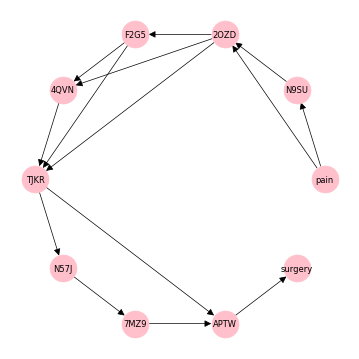


Context: Chronic disease IDCEH3 sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele X9GE, a genetic marker for severe IDCEH3. If the patient self-reports significant pain or the patient has previously received surgery for HUZV, then vital N9SU will be low (less than 1.81 mg/dL). If the patient self-reports significant pain or N9SU is low or the patient has a family history of HCY0, then lab 2OZD will be low (less than 1.79 mg/dL). If 2OZD is low or the patient carries allele LRRJ, then vital F2G5 will be low (less than 2.57 mg/dL). If 2OZD is low or F2G5 is low or the patient carries allele R023, then lab 4QVN will be low (less than 0.49 mg/dL). If 2OZD is low or F2G5 is low or 4QVN is low or the patient has previously received surgery for A3GO, then vital TJKR will be low (less than 0.46 mg/dL). If TJKR is low or the patie

In [26]:
# Four BCCs of varying sizes and topology.
size = [3,4,4,2]
tg = ClinicalNotes(n_per_bcc = size, 
                   bcc_types = ["cycle", "wheel", "cycle", "cycle"])
context = tg.get_causal_context()
patient_history = tg.get_sample_context(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [27]:
# See factual queries.
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1,
   'N9SU': 1,
   '2OZD': 1,
   'F2G5': 1,
   '4QVN': 1,
   'TJKR': 1,
   'N57J': 1,
   '7MZ9': 1,
   'APTW': 1,
   'surgery': 0},
  'True exogenous': {'X9GE': 1,
   'HUZV': 1,
   'HCY0': 0,
   'LRRJ': 0,
   'R023': 0,
   'A3GO': 1,
   'II6Q': 0,
   'KC28': 0,
   '1ON9': 1,
   'XVBK': 0},
  'True response': 0},
 '2OZD': {'Prompt': 'Given these history and physical notes, will lab 2OZD be low? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1,
   'N9SU': 1,
   '2OZD': 1,
   'F2G5': 1,
   '4QVN': 1,
   'TJKR': 1,
   'N57J': 1,
   '7MZ9': 1,
   'APTW': 1,
   'surgery': 0},
  'True exogenous': {'X9GE': 1,
   'HUZV': 1,
   'HCY0': 0,
   'LRRJ': 0,
   'R023': 0,
   'A3GO': 1,
   'II6Q': 0,
   'KC28': 0,
   '1ON9': 1,
   'XVBK': 0},
  'True respon

In [28]:
# See counterfactual query pairs (interventional = True and intervention = False).
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Interventional queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Interventional queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'N9SU': 1, '2OZD': 1, 'F2G5': 1, '4QVN': 1, 'TJKR': 1, 'N57J': 1, '7MZ9': 1, 'APTW': 1, 'surgery': 0}
True exogenous: {'X9GE': 1, 'HUZV': 1, 'HCY0': 0, 'LRRJ': 0, 'R023': 0, 'A3GO': 1, 'II6Q': 0, 'KC28': 0, '1ON9': 1, 'XVBK': 0}
True response: 0

-----------------------

-- ('pain', '2OZD') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will lab 2OZD be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'N9SU': 1, '2OZD': 1, 'F2G5': 1, '4QVN': 1, 'TJKR': 1, 'N57J': 1, '7MZ9': 1, 'APTW': 1, 'surgery': 0}
Tr

In [29]:
print("- Interventional queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Interventional queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'N9SU': 1, '2OZD': 1, 'F2G5': 1, '4QVN': 1, 'TJKR': 1, 'N57J': 1, '7MZ9': 1, 'APTW': 1, 'surgery': 0}
True exogenous: {'X9GE': 1, 'HUZV': 1, 'HCY0': 0, 'LRRJ': 0, 'R023': 0, 'A3GO': 1, 'II6Q': 0, 'KC28': 0, '1ON9': 1, 'XVBK': 0}
True response: 0

-----------------------

-- ('pain', '2OZD') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will lab 2OZD be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'N9SU': 1, '2OZD': 1, 'F2G5': 1, '4QVN': 1, 'TJKR': 1, 'N57J': 1, '7MZ9': 1, 'APTW': 1, 'surgery': 0}
True exogenous: {

In [30]:
# Sample observational data from the structural causal model (SCM).
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,N9SU,2OZD,F2G5,4QVN,TJKR,N57J,7MZ9,APTW,surgery
0,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,1,1,0
4,0,0,1,1,1,1,1,1,1,1


,X9GE,HUZV,HCY0,LRRJ,R023,A3GO,II6Q,KC28,1ON9,XVBK
0,1,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,1,1,1,0,1
2,0,1,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,1,0
4,0,0,1,1,0,0,1,0,1,1


In [31]:
# Sample interventional data from the structural causal model (SCM).
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- TJKR = 1 --


,pain,N9SU,2OZD,F2G5,4QVN,TJKR,N57J,7MZ9,APTW,surgery
0,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,1,1,0
4,0,0,1,1,1,1,1,1,1,1


,X9GE,HUZV,HCY0,LRRJ,R023,A3GO,II6Q,KC28,1ON9,XVBK
0,1,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,1,1,1,0,1
2,0,1,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,1,0
4,0,0,1,1,0,0,1,0,1,1



-- 2OZD = 1 --


,pain,N9SU,2OZD,F2G5,4QVN,TJKR,N57J,7MZ9,APTW,surgery
0,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,1,1,0
4,0,0,1,1,1,1,1,1,1,1


,X9GE,HUZV,HCY0,LRRJ,R023,A3GO,II6Q,KC28,1ON9,XVBK
0,1,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,1,1,1,0,1
2,0,1,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,1,0
4,0,0,1,1,0,0,1,0,1,1



-- APTW = 1 --


,pain,N9SU,2OZD,F2G5,4QVN,TJKR,N57J,7MZ9,APTW,surgery
0,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,1,1,0
4,0,0,1,1,1,1,1,1,1,1


,X9GE,HUZV,HCY0,LRRJ,R023,A3GO,II6Q,KC28,1ON9,XVBK
0,1,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,1,1,1,0,1
2,0,1,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,1,0
4,0,0,1,1,0,0,1,0,1,1



-- pain = 1 --


,pain,N9SU,2OZD,F2G5,4QVN,TJKR,N57J,7MZ9,APTW,surgery
0,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1,1,1


,X9GE,HUZV,HCY0,LRRJ,R023,A3GO,II6Q,KC28,1ON9,XVBK
0,1,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,1,1,1,0,1
2,0,1,1,0,1,1,0,1,1,1
3,0,0,1,1,0,0,0,0,1,0
4,0,0,1,1,0,0,1,0,1,1
